In [26]:
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")

# Only for installation if not installed yet
#BiocManager::install("limma")
#BiocManager::install("mixOmics")
#BiocManager::install("edgeR")
#BiocManager::install("HTSFilter")

In [25]:
## Loading required package: limma
library(limma)
library(RColorBrewer)
library(mixOmics)

library(ggplot2)

library(edgeR)
library(HTSFilter)

library(dplyr)

# First reading the data

#The root directory
dir="."
setwd(dir)

In [3]:
rawData=read.table("genecounts.tsv",header=T,row.names= 1)
CountTable = round(rawData) # necessary for gene counts provided by RSEM

In [4]:
# Keeping only males
CountTable = CountTable %>%
              select_if(!grepl("K", names(.)))

In [5]:
# Using logarithm for representation purpose only
pseudoCounts <- log2(CountTable+1)
head(pseudoCounts)

,cow.testis.neonat1,cow.testis.neonat2,cow.testis.neonat3,cow.testis.adult1,cow.testis.adult2,cow.testis.adult3,cow.liver.B004,cow.liver.B005,cow.liver.B008,cow.liver.B022,cow.liver.B027,cow.liver.B028
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ENSBTAG00000000005,8.980140,8.285402,8.927778,11.103288,11.698705,11.397675,9.407268,9.715962,9.052568,9.287712,9.419960,9.419960
ENSBTAG00000000008,1.000000,1.000000,1.000000,5.781360,5.906891,5.044394,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000
ENSBTAG00000000009,5.672425,5.285402,5.977280,3.906891,4.321928,4.392317,6.426265,5.700440,5.392317,5.727920,5.129283,4.954196
ENSBTAG00000000010,9.144658,8.503826,9.236014,8.262095,8.584963,8.573647,9.257388,9.379378,9.751544,9.738092,9.681238,10.027906
ENSBTAG00000000011,4.459432,4.392317,3.321928,6.066089,6.686501,6.266787,12.721313,13.094738,13.701198,13.448891,14.005010,13.861378
ENSBTAG00000000012,8.330917,8.942515,8.854868,9.818582,10.410451,9.479780,8.744834,8.588715,8.774787,8.599913,8.921841,8.957102


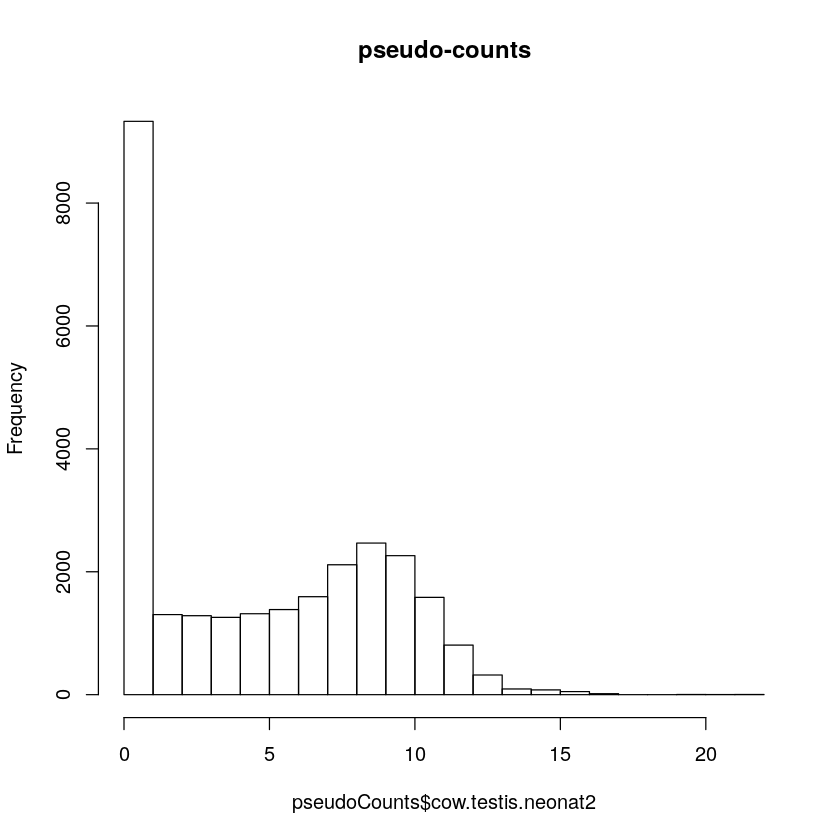

In [8]:
# Just to have an idea of gne counts
# genes with 0 counts are simmy not observed in the tissue under study
hist(pseudoCounts$cow.testis.neonat2,main="pseudo-counts")

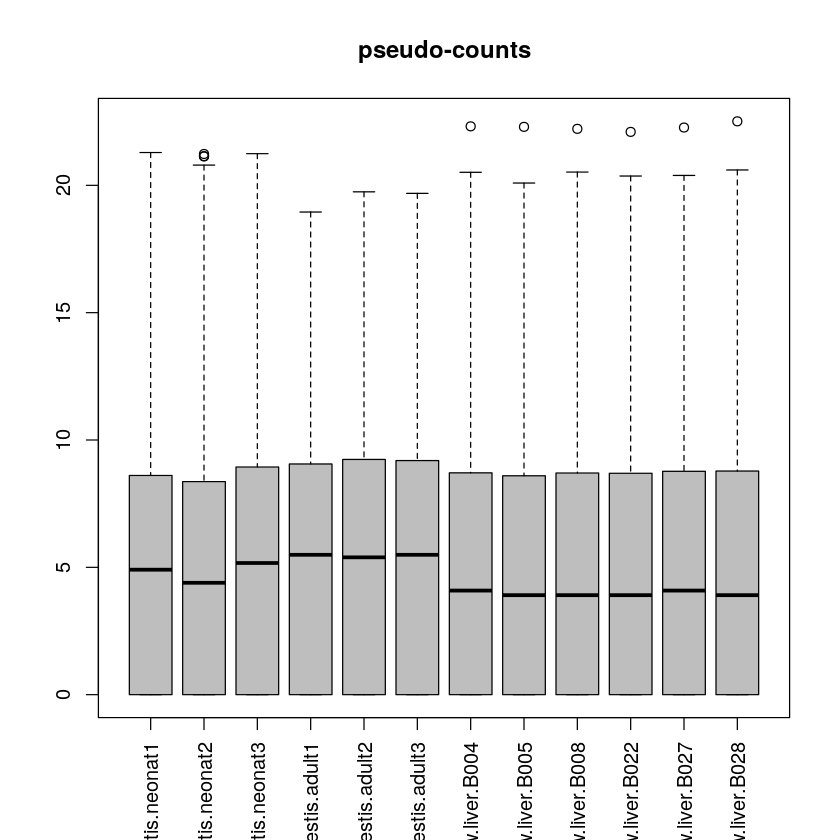

In [10]:
# Here the dispersion for all individuals
boxplot(pseudoCounts, col="gray", las=3,main="pseudo-counts")

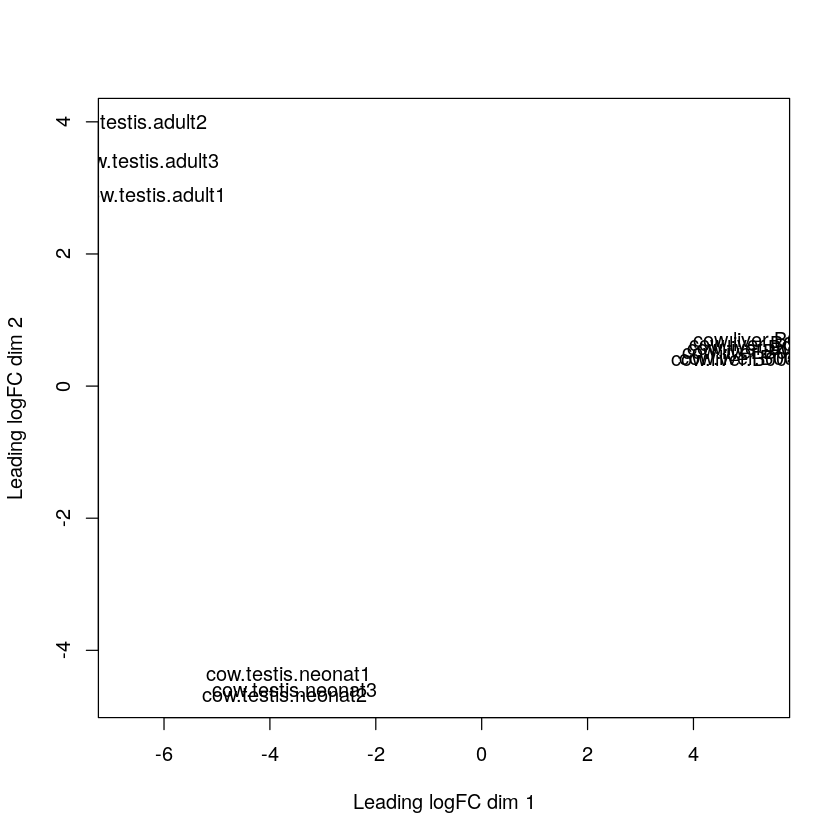

In [12]:
# MDS is simply another flavor of PCA (we can exchange on this point)
# Note the great separation of tissues and of age for testis
plotMDS(pseudoCounts)

In [16]:
#For the purpose of differential expression we have to provide a distinction between two conditions: 
# here liver and testis
sampleInfo <- read.table("design.tsv", header=TRUE,row.names=1)
sampleInfo

,condition
,<fct>
cow-liver-B004,liver
cow-liver-B005,liver
cow-liver-B008,liver
cow-liver-B022,liver
cow-liver-B027,liver
cow-liver-B028,liver
cow-liver-K001,liver
cow-liver-K006,liver
cow-liver-K011,liver


In [17]:
# Keeping only males
sampleInfo = sampleInfo %>% filter(!grepl("K",row.names(sampleInfo) ))

In [18]:
# Here we prepare the differential expression analysis
dgeFull <- DGEList(CountTable, group=sampleInfo$condition)
dgeFull$sampleInfo <- sampleInfo

In [19]:
# Removing zero counts genes
dgeFull <- DGEList(dgeFull$counts[apply(dgeFull$counts, 1, sum) != 0, ],
                   group=dgeFull$samples$group)
head(dgeFull$counts)

,cow.testis.neonat1,cow.testis.neonat2,cow.testis.neonat3,cow.testis.adult1,cow.testis.adult2,cow.testis.adult3,cow.liver.B004,cow.liver.B005,cow.liver.B008,cow.liver.B022,cow.liver.B027,cow.liver.B028
ENSBTAG00000000005,504,311,486,2199,3323,2697,678,840,530,624,684,684
ENSBTAG00000000008,1,1,1,54,59,32,0,0,0,1,0,1
ENSBTAG00000000009,50,38,62,14,19,20,85,51,41,52,34,30
ENSBTAG00000000010,565,362,602,306,383,380,611,665,861,853,820,1043
ENSBTAG00000000011,21,20,9,66,102,76,6752,8747,13318,11181,16440,14882
ENSBTAG00000000012,321,491,462,902,1360,713,428,384,437,387,484,496


In [20]:
# We normalize the data in order to take into account the different overall number of reads between samples
dgeFull <- calcNormFactors(dgeFull, method="TMM")
eff.lib.size <- dgeFull$samples$lib.size*dgeFull$samples$norm.factors
normCounts <- sweep(dgeFull$counts, 2, eff.lib.size, "/")*10^6
# which is equivalent to normCounts <- cpm(dgeFull)
pseudoNormCounts <- log2(normCounts + 1)

dgeFull <- estimateCommonDisp(dgeFull)
dgeFull <- estimateTagwiseDisp(dgeFull)

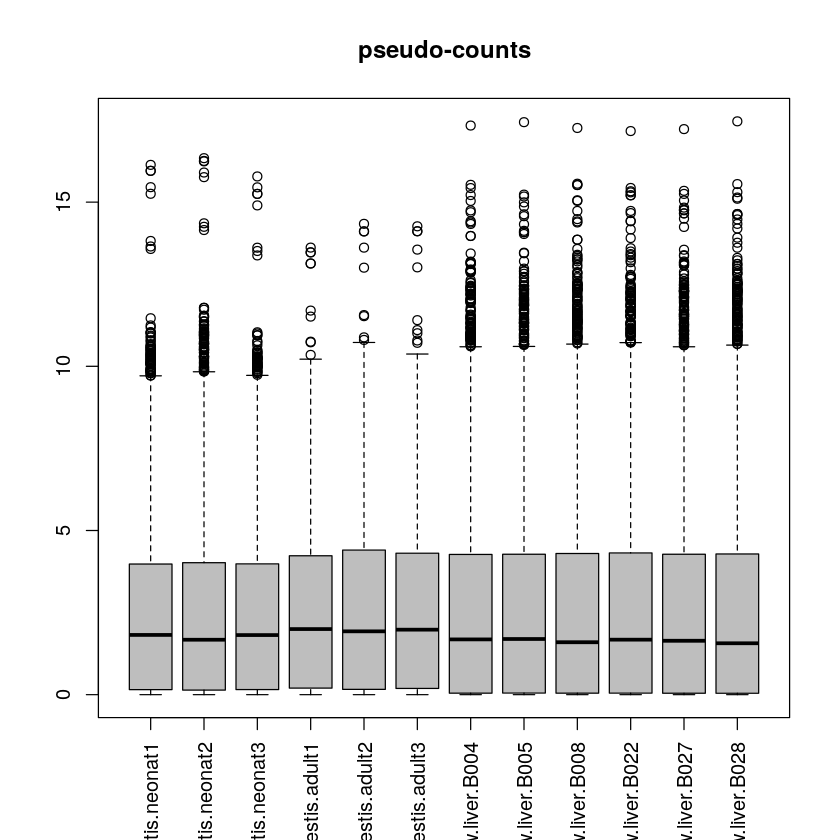

In [22]:
# boxplot after normalization
boxplot(pseudoNormCounts, col="gray", las=3,main="pseudo-counts")

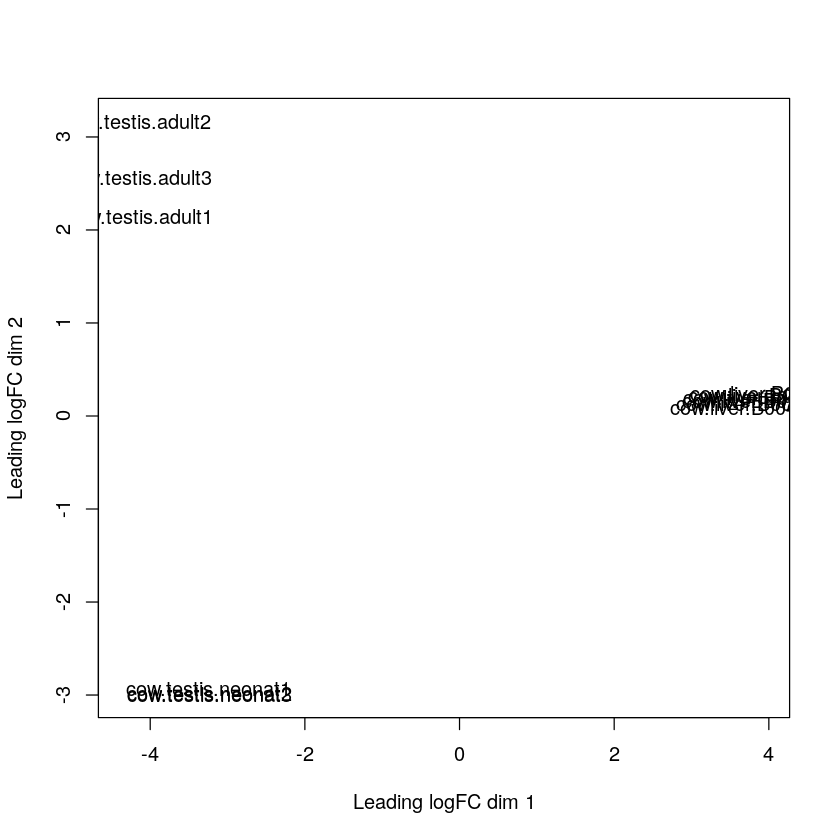

In [23]:
plotMDS(pseudoNormCounts)

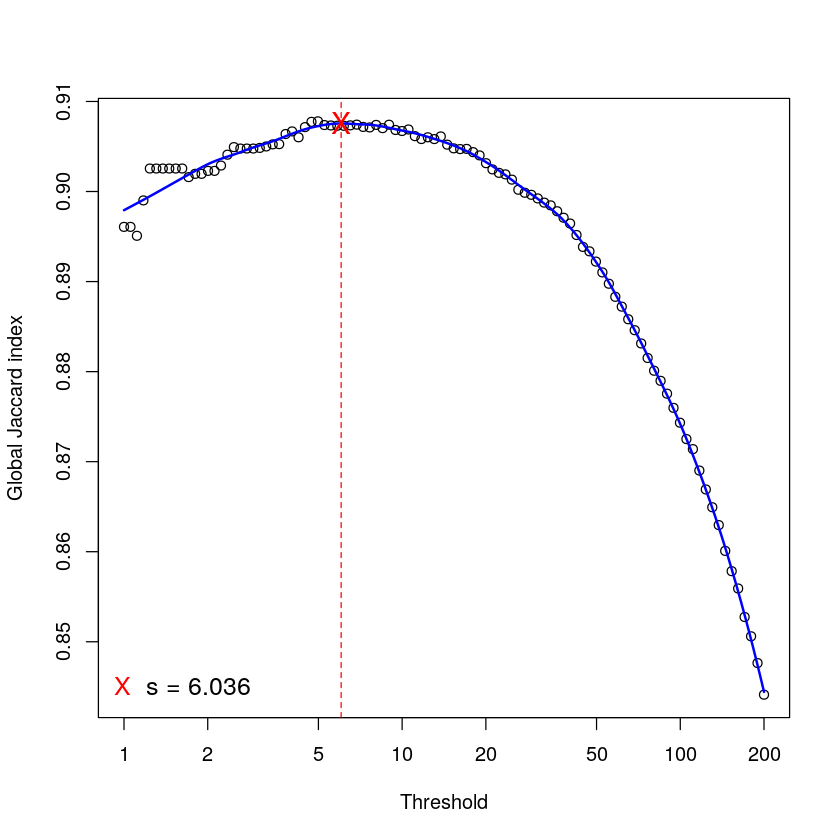

In [27]:
# Here this is simply a cooking recipe, don't pay attention...
filtData <- HTSFilter(dgeFull)$filteredData

In [28]:
# perform an exact test on filtered data
dgeTestFilt <- exactTest(filtData,pair=c("liver","testis"))

resFilt <- topTags(dgeTestFilt, n=nrow(dgeTestFilt$table))

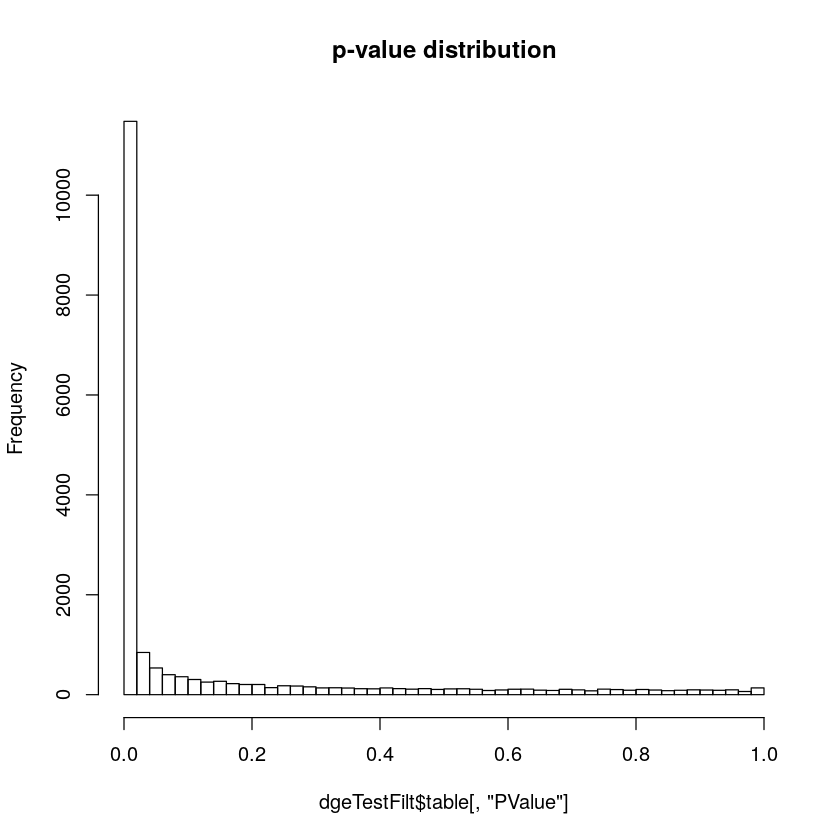

In [29]:
# plot a histogram of unadjusted p-values after filtering
hist(dgeTestFilt$table[,"PValue"], breaks=50,main="p-value distribution")

In [31]:
# Number of genes clearly differentially expressed btween tissue
sum(resFilt$table$FDR < 0.01)

[1] 10164

In [32]:
resFiltFDR <- resFilt$table[resFilt$table$FDR<0.02,]

In [33]:
sigDownReg <- resFiltFDR[order(resFiltFDR$logFC),]
head(sigDownReg)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
ENSBTAG00000020051,-16.70358,7.562804,2.455952e-12,2.333877e-11
ENSBTAG00000019003,-16.61721,7.476460,2.642978e-12,2.501796e-11
ENSBTAG00000033312,-16.14992,7.009375,5.980716e-13,6.190185e-12
ENSBTAG00000008449,-16.13111,6.990566,7.746551e-23,2.124111e-21
ENSBTAG00000021493,-16.03220,6.891725,3.237887e-12,3.027963e-11
ENSBTAG00000045940,-16.00483,6.864368,3.156604e-15,4.408785e-14


#### Expressed specifically in testis
ENSBTAG00000020051 (C16orf82) : https://en.wikipedia.org/wiki/C16orf82

ENSBTAG00000019003 (TPN1) https://www.uniprot.org/uniprot/P17305

In [34]:
sigUpReg <- resFiltFDR[order(resFiltFDR$logFC, decreasing=TRUE),]
head(sigUpReg)

,logFC,logCPM,PValue,FDR
,<dbl>,<dbl>,<dbl>,<dbl>
ENSBTAG00000000085,19.75336,10.612112,1.487253e-118,5.766378e-115
ENSBTAG00000012398,19.47037,10.329139,1.522837e-110,2.270901e-107
ENSBTAG00000018556,18.41059,9.269414,3.061278e-111,5.395086e-108
ENSBTAG00000048094,18.28890,11.693764,6.389357e-122,4.128802e-118
ENSBTAG00000017121,17.88275,16.316636,2.317518e-141,4.492741e-137
ENSBTAG00000048608,17.63266,9.654502,5.494344e-58,7.100890e-56


#### Expressed specifically in liver
ENSBTAG00000012398 (APOC3) https://en.wikipedia.org/wiki/Apolipoprotein_C3

ENSBTAG00000048094 (SERPINA3-7) https://www.genecards.org/cgi-bin/carddisp.pl?gene=SERPINA3

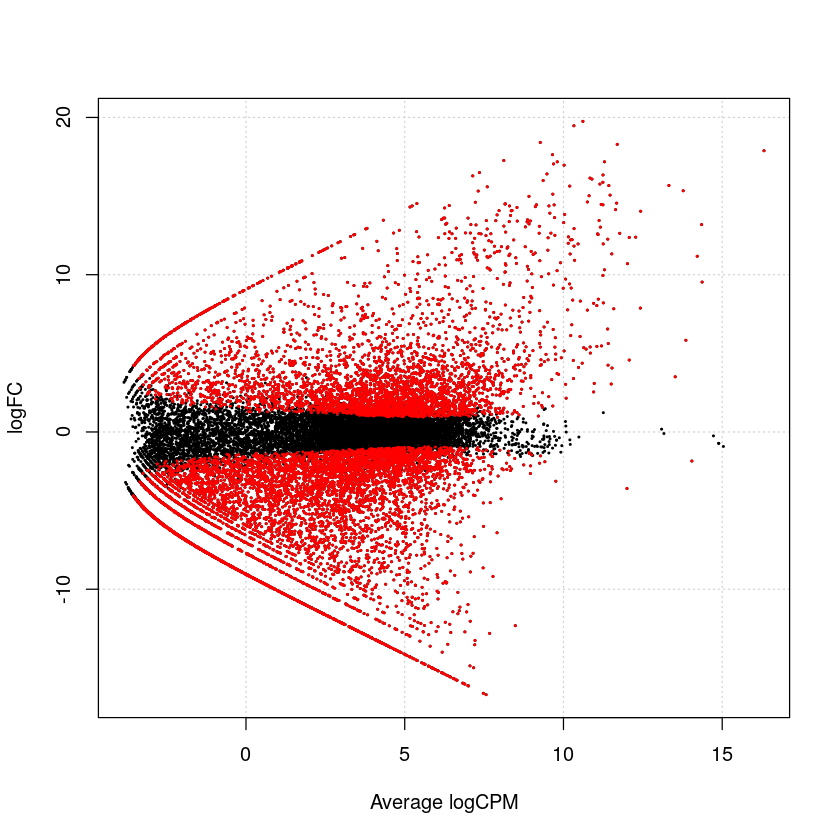

In [35]:
plotSmear(dgeTestFilt, de.tags = rownames(resFilt$table)[which(resFilt$table$FDR<0.01)])